#### Import libraries.

In [1]:

import time
import pandas as pd
import numpy as np
from collections import Counter
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Conv1D
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Input
from keras.layers import MaxPooling1D
from keras.optimizers import AdamW
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot as plt


#### Load the dataset.

In [2]:

df = pd.read_csv('../dataset/original-sam-dataset.csv', sep='|',
                 dtype = {'recordNumber': 'int8',
                          'CZ': 'float64', 'FZ': 'float64', 'Fp1': 'float64', 'F7': 'float64',
                          'F3': 'float64', 'FC1': 'float64', 'C3': 'float64', 'FC5': 'float64', 'FT9': 'float64',
                          'T7': 'float64', 'CP5': 'float64', 'CP1': 'float64', 'P3': 'float64', 'P7': 'float64',
                          'PO9': 'float64', 'O1': 'float64', 'PZ': 'float64', 'OZ': 'float64', 'O2': 'float64',
                          'PO10': 'float64', 'P8': 'float64', 'P4': 'float64', 'CP2': 'float64', 'CP6': 'float64',
                          'T8': 'float64', 'FT10': 'float64', 'FC6': 'float64', 'C4': 'float64', 'FC2': 'float64',
                          'F4': 'float64', 'F8': 'float64', 'Fp2': 'float64', 
                          'Scale': 'int8'})


#### Display the dataset size.

In [3]:
df.shape

(1536000, 34)

#### Build a helper function to convert the set data to the required format to perform the undersampling.

In [4]:

def build_time_window_structure(df):
    # Splits the dataset into "time windows" to be used as a time series list.
    # The function groups each 128 dataset records (CSV lines) into one record.
    # Each record contains 128 steps and each step contains 32 feature values.
    # Parameters:
    #    df: Dataframe to be splitted.
    # Return:
    #    X_array (list): First list contains all time windows.
    #    y_array (list): Second list contains all target values.
    print("\nStarting build_time_window_structure function...")
    steps_number = 1280
    first_feat_index = 1
    last_feat_index = 33
    df_values = df.iloc[:, first_feat_index:last_feat_index].values
    scale_values = df["Scale"].values
    num_segments = len(scale_values) // steps_number  
    X_array = np.empty((num_segments, steps_number * (last_feat_index - first_feat_index)), dtype = df_values.dtype)
    y_array = np.empty(num_segments, dtype = scale_values.dtype)
    for i in range(num_segments):
        start_idx = i * steps_number
        end_idx = start_idx + steps_number
        sub_matrix_values = df_values[start_idx:end_idx].flatten()
        X_array[i] = sub_matrix_values
        y_array[i] = scale_values[start_idx]
    X_array = X_array.tolist()
    y_array = y_array.tolist()
    print("Quantity of samples (features) => ", len(X_array))
    print("Quantity os samples (labels) => ", len(y_array))
    print("Finishing build_time_window_structure function.")
    return X_array, y_array


#### Define a function to performe SMOTE to balance the dataset.

In [5]:

def apply_smote_resample(X_array, y_array, apply_resample = False, quantity_of_resample = 0):
    # Apply SMOTE to balance the dataset and resample for data augmentation.
    # Parameters:
    #    X_array (np.array): array of features values.
    #    y_array (np.array): array of target values.
    #    apply_resample (boolean): resample will be performe if True.
    #    quantity_of_resample (int): number of samples generated by resample.
    # Return:
    #    X_oversampled (np.array): array of features values.
    #    y_oversampled (np.array): array of target values.
    print("\nGenerating upsampling using SMOTE...")
    smote = SMOTE(sampling_strategy = "auto", k_neighbors = 5, random_state = 42)
    X_array_res, y_array_res = smote.fit_resample(X_array, y_array)
    if apply_resample is True:
        X_oversampled, y_oversampled = resample(X_array_res,
                                                y_array_res,
                                                replace = True,
                                                n_samples = quantity_of_resample,
                                                stratify = y_array_res,
                                                random_state = 42)
    else:
        X_oversampled, y_oversampled = X_array_res, y_array_res
    print("{} samples after upsampling.".format(len(y_oversampled)))
    print(f"Class distribution for training after upsampling: {Counter(y_oversampled)}")
    print("Finishing upsampling.\n")
    return X_oversampled, y_oversampled



#### Define a function to train a CNN model.

In [6]:

number_of_steps = 1280
number_of_features = 32

# Define the number of folds (10 k-Fold).
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
# Normalize data using RobustScaler.
pt = RobustScaler()

es = EarlyStopping(monitor = "val_loss", mode = "min", verbose = 1, patience = 30, restore_best_weights = True)

def train_cnn_model(cnn_model, X_arr, y_arr, apply_smote = False, apply_resample = False, quantity_of_resample = 0):
    # Train a CNN model.
    # Parameters:
    #    cnn_model (Sequential): model to be trained.
    #    X_arr (np.array): array of features values.
    #    y_arr (np.array): array of target values.
    #    apply_smote (boolean): SMOTE will be performe if True.
    #    apply_resample (boolean): resample will be performe if True.
    #    quantity_of_resample (int): number of samples generated by resample.
    # Returns:
    #    history (History object): history of training metrics.
    train_accuracy_by_fold = []
    test_accuracy_by_fold = []
    history_by_fold = []
    y_predclass_for_report = []
    y_testclass_for_report = []
    fold_number = 1
    start_time = time.time()
    print("\nStarting training...")
    for train_index, test_index in skf.split(X_arr, y_arr):
        print("\nTraining fold {}".format(fold_number))
        if apply_smote is True:
            X_oversampled, y_oversampled = apply_smote_resample(X_arr[train_index], y_arr[train_index],
                                                                apply_resample, quantity_of_resample)
        else:
            X_oversampled, y_oversampled = X_arr[train_index], y_arr[train_index]
        X_train_scaled = pt.fit_transform(X_oversampled)
        X_test_scaled = pt.transform(X_arr[test_index])
        # Reshape the structure data to be compatible with pattern [samples, timesteps, features].
        X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], number_of_steps, number_of_features))
        X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], number_of_steps, number_of_features))
        history = cnn_model.fit(X_train_reshaped, y_oversampled, validation_split = 0.01,
                                epochs = 300, batch_size = 32, verbose = 1, callbacks = [es])
        _, train_accuracy = cnn_model.evaluate(X_train_reshaped, y_oversampled, verbose = 0)
        _, test_accuracy = cnn_model.evaluate(X_test_reshaped, y_arr[test_index], verbose = 0)
        train_accuracy_by_fold.append(train_accuracy)
        test_accuracy_by_fold.append(test_accuracy)
        history_by_fold.append(history)
        y_predclass_for_report.extend(np.argmax(cnn_model.predict(X_test_reshaped), axis = 1))
        y_testclass_for_report.extend(y_arr[test_index])
        fold_number += 1
    elapsed_seconds = time.time() - start_time
    print("\nTime taken for training: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_seconds)))
    print("\n")
    # Show metrics.
    for i in range(len(history_by_fold)):
        print("Fold {} - Train Accuracy {:.4f} - Test Accuracy {:.4f}".format((i + 1),
              train_accuracy_by_fold[i], test_accuracy_by_fold[i]))
    print("\nMean Train Accuracy: {:.4f} ".format(np.mean(train_accuracy_by_fold)))
    print("Mean Test Accuracy: {:.4f} ".format(np.mean(test_accuracy_by_fold)))
    print("\nEvaluate other metrics:")
    print(classification_report(y_testclass_for_report, y_predclass_for_report, zero_division = 0))
    return history_by_fold


#### Train a Convolutional Neural Network model and evaluate the metrics.
- Layer architecture => Conv1D (64) + Conv1D (32) + Conv1D (16) + MaxPooling1D + Dense (32) + Dense (11)

In [ ]:

def create_baseline():
    act_function = "relu"
    kernel_init = "he_uniform"
    model = Sequential()
    model.add(Input(shape=(number_of_steps, number_of_features)))
    model.add(Conv1D(filters = 64, kernel_size = 3, activation = act_function,
                     kernel_initializer = kernel_init))
    model.add(Conv1D(filters = 32, kernel_size = 3, activation = act_function,
                     kernel_initializer = kernel_init))
    model.add(Conv1D(filters = 16, kernel_size = 3, activation = act_function,
                     kernel_initializer = kernel_init))
    model.add(MaxPooling1D(pool_size = 2))
    model.add(Flatten())
    model.add(Dense(32, activation = act_function))
    model.add(Dense(11, activation = 'softmax'))
    opt = AdamW(learning_rate = 0.001)
    model.compile(loss = "sparse_categorical_crossentropy", optimizer = opt, metrics = ["accuracy"])
    model.summary()
    return model

X_list, y_list = build_time_window_structure(df)
X_arr = np.array(X_list)
y_arr = np.array(y_list)

model = create_baseline()
history_by_fold = train_cnn_model(model, X_arr, y_arr, apply_smote = True)



Starting build_time_window_structure function...
Quantity of samples (features) =>  1200
Quantity os samples (labels) =>  1200
Finishing build_time_window_structure function.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 1278, 64)       │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 1276, 32)       │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 1274, 16)       │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 637, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 10192)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │       326,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 11)             │           363 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 340,475 (1.30 MB)

 Trainable params: 340,475 (1.30 MB)

 Non-trainable params: 0 (0.00 B)


Starting training...

Training fold 1

Generating upsampling using SMOTE...
2970 samples after upsampling.
Class distribution for training after upsampling: Counter({np.int64(6): 270, np.int64(7): 270, np.int64(4): 270, np.int64(3): 270, np.int64(5): 270, np.int64(8): 270, np.int64(9): 270, np.int64(2): 270, np.int64(10): 270, np.int64(1): 270, np.int64(0): 270})
Finishing upsampling.

Epoch 1/300
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.2097 - loss: 2.6342 - val_accuracy: 1.0000 - val_loss: 0.0198
Epoch 2/300
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7652 - loss: 0.8288 - val_accuracy: 1.0000 - val_loss: 0.0195
Epoch 3/300
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9595 - loss: 0.1808 - val_accuracy: 1.0000 - val_loss: 4.3679e-04
Epoch 4/300
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9937 - loss: 0.0537 - val_accuracy: 1.0000 - val_loss: 0.0023
Epoch 5/300
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 1.0000 - loss: 0.0130 - val_ac

#### Train a Convolutional Neural Network model and evaluate the metrics.
- Layer architecture => Conv1D (64) + Conv1D (32) + Conv1D (16) + MaxPooling1D + Dense (32) + Dense(32) + Dense(32) + Dense (11)

In [7]:

def create_v1():
    act_function = "relu"
    kernel_init = "he_uniform"
    model = Sequential()
    model.add(Input(shape=(number_of_steps, number_of_features)))
    model.add(Conv1D(filters = 64, kernel_size = 3, activation = act_function,
                     kernel_initializer = kernel_init))
    model.add(Conv1D(filters = 32, kernel_size = 3, activation = act_function,
                     kernel_initializer = kernel_init))
    model.add(Conv1D(filters = 16, kernel_size = 3, activation = act_function,
                     kernel_initializer = kernel_init))
    model.add(MaxPooling1D(pool_size = 2))
    model.add(Flatten())
    model.add(Dense(32, activation = act_function, kernel_initializer = kernel_init))
    model.add(Dense(32, activation = act_function, kernel_initializer = kernel_init))
    model.add(Dense(32, activation = act_function, kernel_initializer = kernel_init))
    model.add(Dense(11, activation = 'softmax'))
    opt = AdamW(learning_rate = 0.001)
    model.compile(loss = "sparse_categorical_crossentropy", optimizer = opt, metrics = ["accuracy"])
    model.summary()
    return model

X_list, y_list = build_time_window_structure(df)
X_arr = np.array(X_list)
y_arr = np.array(y_list)

model = create_v1()
history_by_fold = train_cnn_model(model, X_arr, y_arr, apply_smote = True)



Starting build_time_window_structure function...
Quantity of samples (features) =>  1200
Quantity os samples (labels) =>  1200
Finishing build_time_window_structure function.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1278, 64)       │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1276, 32)       │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 1274, 16)       │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 637, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10192)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       326,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 11)             │           363 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 342,587 (1.31 MB)

 Trainable params: 342,587 (1.31 MB)

 Non-trainable params: 0 (0.00 B)


Starting training...

Training fold 1

Generating upsampling using SMOTE...
2970 samples after upsampling.
Class distribution for training after upsampling: Counter({np.int64(6): 270, np.int64(7): 270, np.int64(4): 270, np.int64(3): 270, np.int64(5): 270, np.int64(8): 270, np.int64(9): 270, np.int64(2): 270, np.int64(10): 270, np.int64(1): 270, np.int64(0): 270})
Finishing upsampling.

Epoch 1/300
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.1363 - loss: 2.7108 - val_accuracy: 1.0000 - val_loss: 0.1157
Epoch 2/300
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6885 - loss: 0.9939 - val_accuracy: 1.0000 - val_loss: 0.0191
Epoch 3/300
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9021 - loss: 0.3091 - val_accuracy: 1.0000 - val_loss: 0.0042
Epoch 4/300
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9672 - loss: 0.1256 - val_accuracy: 1.0000 - val_loss: 0.0140
Epoch 5/300
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9810 - loss: 0.0711 - val_accura

#### Train a Convolutional Neural Network model and evaluate the metrics.
- Layer architecture => Conv1D (64) + Conv1D (32) + Conv1D (16) + MaxPooling1D + Dense (128) + Dense (11)

In [7]:

def create_v2():
    act_function = "relu"
    kernel_init = "he_uniform"
    model = Sequential()
    model.add(Input(shape=(number_of_steps, number_of_features)))
    model.add(Conv1D(filters = 64, kernel_size = 3, activation = act_function,
                     kernel_initializer = kernel_init))
    model.add(Conv1D(filters = 32, kernel_size = 3, activation = act_function,
                     kernel_initializer = kernel_init))
    model.add(Conv1D(filters = 16, kernel_size = 3, activation = act_function,
                     kernel_initializer = kernel_init))
    model.add(MaxPooling1D(pool_size = 2))
    model.add(Flatten())
    model.add(Dense(128, activation = act_function, kernel_initializer = kernel_init))
    model.add(Dropout(0.2))
    model.add(Dense(11, activation = 'softmax'))
    opt = AdamW(learning_rate = 0.001)
    model.compile(loss = "sparse_categorical_crossentropy", optimizer = opt, metrics = ["accuracy"])
    model.summary()
    return model

X_list, y_list = build_time_window_structure(df)
X_arr = np.array(X_list)
y_arr = np.array(y_list)

model = create_v2()
history_by_fold = train_cnn_model(model, X_arr, y_arr, apply_smote = True)



Starting build_time_window_structure function...
Quantity of samples (features) =>  1200
Quantity os samples (labels) =>  1200
Finishing build_time_window_structure function.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1278, 64)       │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1276, 32)       │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 1274, 16)       │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 637, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10192)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,304,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,320,059 (5.04 MB)

 Trainable params: 1,320,059 (5.04 MB)

 Non-trainable params: 0 (0.00 B)


Starting training...

Training fold 1

Generating upsampling using SMOTE...
2970 samples after upsampling.
Class distribution for training after upsampling: Counter({np.int64(6): 270, np.int64(7): 270, np.int64(4): 270, np.int64(3): 270, np.int64(5): 270, np.int64(8): 270, np.int64(9): 270, np.int64(2): 270, np.int64(10): 270, np.int64(1): 270, np.int64(0): 270})
Finishing upsampling.

Epoch 1/300
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.2166 - loss: 3.2210 - val_accuracy: 1.0000 - val_loss: 0.0499
Epoch 2/300
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7348 - loss: 0.8651 - val_accuracy: 1.0000 - val_loss: 0.0051
Epoch 3/300
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9186 - loss: 0.2951 - val_accuracy: 1.0000 - val_loss: 1.8083e-04
Epoch 4/300
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9596 - loss: 0.1366 - val_accuracy: 1.0000 - val_loss: 1.5622e-04
Epoch 5/300
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9799 - loss: 0.0718 - va

#### Show loss history by epochs.

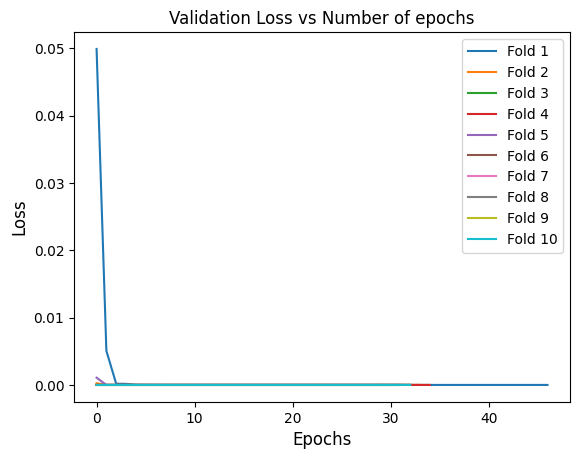

In [8]:

# Plot loss history
for i in range(len(history_by_fold)):
    plt.plot(history_by_fold[i].history["val_loss"], label = "Fold {}".format(i + 1))
plt.title("Validation Loss vs Number of epochs", fontsize = 12)
plt.xlabel("Epochs", fontsize = 12)
plt.ylabel("Loss", fontsize = 12)
plt.legend()
plt.show()


#### Show accuracy history by epochs.

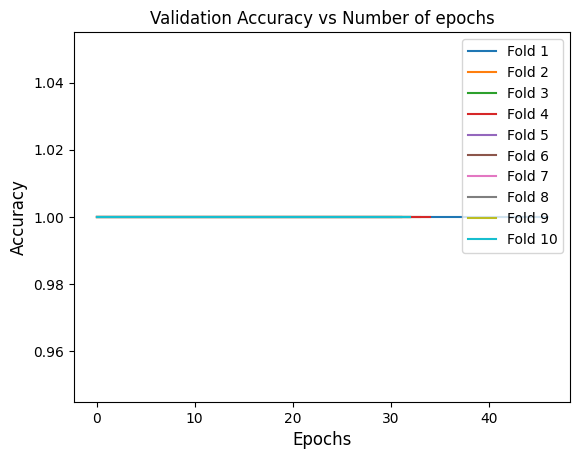

In [9]:

# Plot accuracy history
for i in range(len(history_by_fold)):
    plt.plot(history_by_fold[i].history["val_accuracy"], label = "Fold {}".format(i + 1))
plt.title("Validation Accuracy vs Number of epochs", fontsize = 12)
plt.xlabel('Epochs', fontsize = 12)
plt.ylabel('Accuracy', fontsize = 12)
plt.legend()
plt.show()
